<h2>A.I. based X-Ray analysis for human lungs. Implemented by Keras and Tensorflow</h2>
<p>Prepared by Vytautas Bielinskas, vytautas.bielinskas@gmail.com</p>
<h3>Part 1: Construct the CNN Architecture and train the model with real data</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from tensorflow.keras import regularizers

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

from vb100_utils import *
from shutil import copyfile
import shutil
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
!pip install sklearn
!pip install -U matplotlib
!pip install Pillow

  Using cached https://files.pythonhosted.org/packages/cc/eb/fd7a5f3c1484e8d2590ff94ca0b89941940a916394f719ab3bb7279e1970/matplotlib-3.1.1-cp36-cp36m-win_amd64.whl
  Found existing installation: matplotlib 2.2.3
    Uninstalling matplotlib-2.2.3:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\program files\\python36\\lib\\site-packages\\__pycache__\\pylab.cpython-36.pyc'
Consider using the `--user` option or check the permissions.



In [2]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(keras.__version__))

Tensorflow version = 2.5.0-dev20201117
Keras version = 2.4.3


<b># Data Pre-processing automatically</b>

In [11]:
# Data Folder System: -------------------------------------------------
# data
# -- test (234 + 390 = 624)
# ---- NORMAL
# ------ IM-0001-0001.jpeg
# ------ IM-0003-0001.jpeg
# ------ (234 images)
# ---- PNEUMONIA
# ------ person1_virus_6.jpeg
# ------ person109_bacteria_526.jpeg
# ------ (390 images)
# -- train (1341 + 3875 = 5216)
# ---- NORMAL
# ------ IM-0115-0001.jpeg
# ------ IM-0117-0001.jpeg
# ------ (1341 images)
# ---- PNEUMONIA
# ------ person1_bacteria_1.jpeg
# ------ person162_virus_322.jpeg
# ------ (3875 images)
# -- val (8 + 8 = 16)
# ---- NORMAL
# ------ NORMAL2-IM-1427-0001.jpeg
# ------ NORMAL2-IM-1440-0001.jpeg
# ------ (8 images)
# ---- PNEUMONIA
# ------ person1946_bacteria_4874.jpeg
# ------ person1951_bacteria_4882.jpeg
# ------ (8 images)

# In total: 234 + 390 + 3875 + 8 + 8 = 4515 imges (1.2GB of data)
# -----------------------------------------------------------------------

<img src="imgs/01.jpeg" alt="Folder system" width="550">

In [3]:
# CONSTANTS FOR DIRECTORIES
TRAIN_DIR = 'data/train'
VALID_DIR = 'data/val'
TEST_DIR = 'data/test'
l_DIRS = [TRAIN_DIR, VALID_DIR, TEST_DIR]
POSITIVE_CLASS = 'NORMAL'
ABSTRACT_CLASS = 'PNEUMONIA'

# CONSTANTS FOR IMAGE PARAMETERS
INPUT_W = 1200 # pixels
INPUT_H = 900  # pixels
DIVIDER = 3.6
INPUT_DIM = (int(INPUT_W/DIVIDER), int(INPUT_H/DIVIDER), 1)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64 
BATCH_SIZE_VALID = 16
NORMALIZER = 1./255
IMAGE_FORMAT = 'jpeg'

# Output Info
print('Image dimmensions for CNN = {}'.format(INPUT_DIM))

Image dimmensions for CNN = (333, 250, 1)


In [4]:
if abstract_class_exists(ABSTRACT_CLASS, l_DIRS):
    structure_origin_data(l_DIRS, IMAGE_FORMAT, POSITIVE_CLASS)

classes = classes_for_each_set(l_DIRS)

print('Catched classes for the model:\n{}'.format(classes))

Performing raw data restructuring. Please wait.

Current Working Directory: C:\Users\User\Downloads\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master

*** Handling workspace: data/train ***
| Folders found:
|| ['C:\\Users\\User\\Downloads\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master/data/train\\BACTERIA', 'C:\\Users\\User\\Downloads\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master/data/train\\NORMAL', 'C:\\Users\\User\\Downloads\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master/data/train\\PNEUMONIA', 'C:\\Users\\User\\Downloads\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master\\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master/data/train\\VIRUS']

| Entering to: C:\Users\User\Downloads\Pneumonia-X-Rays-of-Human-Lungs-AI-project-master\Pneumonia-X-Rays-of-Human-Lungs-AI-projec

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 16 images belonging to 2 classes.


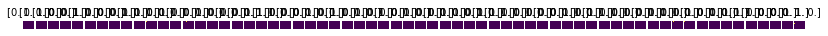

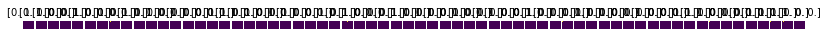

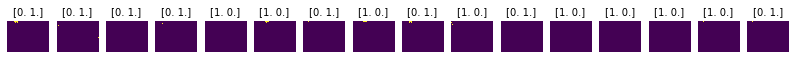

In [5]:
# Generating and Plot Image Data from Train Set
TRAIN_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TRAIN_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TRAIN'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TRAIN)

imgs, labels = next(TRAIN_BATCHES)  # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)          # <-- Plot Images with labels
#train_imgs = rgb_to_grayscale(imgs) # <-- Convert RGB images to Grayscale ones by Tensorflow
#train_labels = labels

# Generating and Plot Image Data from Test Set
TEST_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TEST_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TEST'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TEST)

imgs, labels = next(TEST_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)          # <-- Plot Images with labels
#test_imgs = rgb_to_grayscale(imgs)  # <-- Convert RGB images to Grayscale ones by Tensorflow
#test_labels = labels

# Generating and Plot Image Data from Validation Set
VAL_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(VALID_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['VALIDATION'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_VALID)

imgs, labels = next(VAL_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=labels)         # <-- Plot Images with labels
#val_imgs = rgb_to_grayscale(imgs)  # < -- Convert RGB images to Grayscale ones by Tensorflow
#val_labels = labels

In [6]:
# Output of Generators
for data_batch, label_batch in TRAIN_BATCHES:
    print('data batch shape = {}'.format(data_batch.shape))
    print('labels batch shape = {}'.format(label_batch.shape))
    break

data batch shape = (64, 333, 250, 1)
labels batch shape = (64, 3)


<b># Build CNN with Keras</b>

In [7]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(INPUT_DIM)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(128, (4, 4))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (2, 2))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.02))) 
model.add(Activation('relu'))

model.add(Dense(3)) 
model.add(Activation('softmax')) 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 329, 246, 64)      1664      
_________________________________________________________________
activation (Activation)      (None, 329, 246, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 82, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 79, 128)      131200    
_________________________________________________________________
activation_1 (Activation)    (None, 106, 79, 128)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 39, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 37, 512)       5

In [9]:
# Define an optimizer for the model
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.85, nesterov=True)
#opt = RMSprop(lr=0.001, rho=0.8, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [10]:
print('steps_per_epoch={}'.format(int(5215 / BATCH_SIZE_TRAIN)))
print('validation_steps={}'.format(int(624 / BATCH_SIZE_TEST)))

steps_per_epoch=81
validation_steps=9


<b># Train the CNN with Training data</b>

In [ ]:
%%time
model.fit_generator(
    TRAIN_BATCHES,
    steps_per_epoch=len(TRAIN_BATCHES),
    validation_data=TEST_BATCHES,
    validation_steps=len(TEST_BATCHES),
    epochs=100,
    verbose=2
)

# Parameters meanings:
# steps_per_epoch = number_of_images / batch_size = 5215 / 64 = 82:
# --- Total number of steps (batches of samples) to yield from generator before declaring one 
#     epoch finished and starting the next epoch. It should typically be equal to the number 
#     of unique samples of your dataset divided by the batch size.
# Verbose:
# -- 0 (quiet): you just get the total numbers of tests executed and the global result
# -- 1 (default): you get the same plus a dot for every successful test or a F for every failure
# -- 2 (verbose): you get the help string of every test and the result

Epoch 1/100


In [20]:
plot_model_result(model)

KeyError: 'val_acc'

<p><i>More saved models are stored on the project directory as <code>good_models</code>. There are subsystem contain graphs, weights and CNN architectures for each training experiment.</i></p>

In [21]:
# Save the results as separate lists
df = save_model_result(model)

KeyError: 'val_acc'

<h3>Part 2. Make it resuable</h3>

In [22]:
# Save the Model Weights
model.save_weights('model_100_eopchs_adam_20191030_01.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('model_adam_20191030_01.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


In [17]:
# Useful references:
# -- https://www.youtube.com/watch?v=daovGOlMbT4
# -- https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [23]:
# ------------------------------------------------------------------------
# Load saved model and its weights
'''
>> Model weights are saved to HDF5 format.
>> The model structure can be described and saved using two different formats: JSON and YAML.
'''

# Import dependencies
from keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from tensorflow.python.framework import ops
ops.reset_default_graph()
import h5py 
from PIL import Image
import PIL
from vb100_utils import *

In [24]:
print('h5py version is {}'.format(h5py.__version__))

h5py version is 2.10.0


In [25]:
# Get the architecture of CNN
json_file = open('./good_models/20190807/02/model_adam.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Get weights into the model
loaded_model.load_weights('./good_models/20190807/02/model_100_eopchs_adam_20190807.h5')

In [26]:
'''
Here I will simulate what will happen during deployment on a cloud.
Reading a given image, preparing it for CNN evaluation and make
a predictions with a returned class from a dictionary that has
been used for training.
'''

# Define optimizer and run
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')


'''
Important Note! For this block optimizer is entered manualy as Tensorflow object.
For future, need to change it for include it as variable with full set of
parameters as Tensorflow variable.

'''

IMG = Image.open('data/val/BACTERIA/person1950_bacteria_4881.jpeg')
print(type(IMG))
IMG = IMG.resize((342, 257))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(1, 342, 257, 1)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = loaded_model.predict_classes(IMG)
print(predictions, predictions_c)

FileNotFoundError: [Errno 2] No such file or directory: 'data/val/BACTERIA/person1950_bacteria_4881.jpeg'

In [9]:
classes = {'TRAIN': ['BACTERIA', 'NORMAL', 'VIRUS'],
           'VALIDATION': ['BACTERIA', 'NORMAL'],
           'TEST': ['BACTERIA', 'NORMAL', 'VIRUS']}

predicted_class = classes['TRAIN'][predictions_c[0]]
print('We think that is {}.'.format(predicted_class.lower()))

We think that is virus.


<h2>That is all for Jupyter.</h2>
<p>Go to deployment stage now.</p>